# Notebook to visualize and process LISST-VSF data

In [1]:
import os
import glob
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
opj = os.path.join
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
#%matplotlib ipympl
from pylisst import calib,driver,process,utils,__version__
calfact = calib()
opj = os.path.join
__version__

'1.0.1'

In [2]:
pkg_dir = '/DATA/instrument/lisst-vsf/pylisst'
rootdir = '/DATA/projet/gernez/hablab/'
figdir=opj(rootdir,'fig')

idir=opj(rootdir,'lisst_vsf','raw')

info = pd.read_csv(opj(idir,'LISST_VSF_Sample_Filenames_th.csv'))
info[info.ID.str.contains('BEAD')]

,Date,UTC time,ID,filename,Comment,median_radius
21,21/04/2022,15:10,BEADS3mic_S_C1_R1,V1111510.VSF,NaN,1.5000
22,21/04/2022,15:14,BEADS3mic_S_C1_R2,V1111514.VSF,NaN,1.5000
23,21/04/2022,15:44,BEADS1mic_S_C1_R1,V1111544.VSF,NaN,0.5000
24,21/04/2022,15:49,BEADS1mic_S_C1_R2,V1111549.VSF,NaN,0.5000
25,21/04/2022,16:13,BEADS0.7mic_S_C1_R1,V1111613.VSF,NaN,0.3510
26,21/04/2022,16:17,BEADS0.7mic_S_C1_R2,V1111617.VSF,NaN,0.3510
27,21/04/2022,16:44,BEADS0.3mic_S_C1_R1,V1111644.VSF,NaN,0.1515
28,21/04/2022,16:48,BEADS0.3mic_S_C1_R2,V1111648.VSF,NaN,0.1515
60,17/04/2023,16:29,BEADS1mic_S_C1,V1071629.VSF,remove samples number 60 to 70 on LISST-200X,NaN
81,20/04/2023,10:15,BEADS3mic_S_C2,V1101015.VSF,NaN,NaN


In [3]:
# set blank file
filez=opj(idir,'Z1071316.VSF')

In [4]:
filename = 'V1111549.VSF'
file = opj(idir,filename)
# set bead size median radius:
rn_med =.5

In [5]:
scat = driver(file)
scat.reader()
zsc = driver(filez)
zsc.reader()
plisst = process(scat, zsc, calfact)
plisst.full_process()

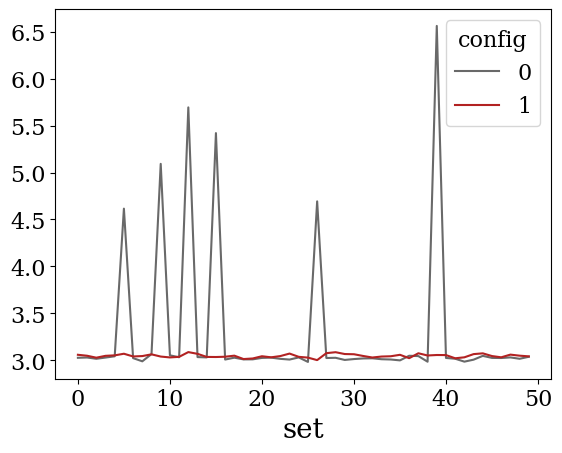

In [6]:

plisst.beam_c.plot(hue='config')

In [14]:
mie=True
if mie:
    from mie_perso import psd, mie_multiprocess

    # ---------------------------------
    # get Mie simulations
    # ---------------------------------
    pmie = mie_multiprocess.processor()
    size_param = psd.size_param
    psd_ = psd.psd()

    # -------------------------------------
    # Generate mueller matrices for a series
    # of size parameters x = np.pi * diameter / wavelength (unitless)
    # -------------------------------------
    wl = 515
    nMedium = 1.3199 + 6878 / wl ** 2 - 1.132e9 / wl ** 4 + 1.11e14 / wl ** 6
    wl_medium = wl / nMedium
    npolystyrene = 1.60
    m = npolystyrene / nMedium - 0.000j

    theta = np.linspace(0, np.pi, 3600)
    x = np.logspace(np.log10(1), 2, 1001)
    ofile = opj(pkg_dir,'data','mueller_mie_' + format(m, '1.3f') + '_t3600.nc')
    if os.path.exists(ofile):
        print(ofile)

In [7]:
# get the refractive index at a given wavelength
wl = 515
nMedium = 1.3199 + 6878 / wl ** 2 - 1.132e9 / wl ** 4 + 1.11e14 / wl ** 6
wl_medium = wl / nMedium
npolystyrene = 1.60
m = npolystyrene / nMedium - 0.000j
format(m, '1.3f')

'1.198+0.000j'

In [8]:
from mie_perso import psd, mie_multiprocess
ofile = opj(pkg_dir,'data','mueller_mie_' + format(m, '1.3f') + '_t3600.nc')
if os.path.exists(ofile):
    mueller = xr.open_dataset(ofile)
else:
    #mueller = pmie.ScatMat_mp(m, x, theta)
    #mueller.to_netcdf(ofile)
    from mie_perso import psd, mie_multiprocess

    # ---------------------------------
    # get Mie simulations
    # ---------------------------------
    pmie = mie_multiprocess.processor()
    
    # -------------------------------------
    # Generate mueller matrices for a series
    # of size parameters x = np.pi * diameter / wavelength (unitless)
    # -------------------------------------
    wl = 515
    nMedium = 1.3199 + 6878 / wl ** 2 - 1.132e9 / wl ** 4 + 1.11e14 / wl ** 6
    wl_medium = wl / nMedium
    npolystyrene = 1.60
    m = npolystyrene / nMedium - 0.000j

    theta = np.linspace(0, np.pi, 3600)
    x = np.logspace(np.log10(1), 2, 1001)
    ofile = opj(pkg_dir,'data','mueller_mie_' + format(m, '1.3f') + '_t3600.nc')
    if os.path.exists(ofile):
        print(ofile)

# -------------------------------------
# convert mueller matrices for a series
# of diameters for a given couple of
# wavelength (in vacuum) and refractive index (in medium)
# for a medium of refractive index nMedium
# -------------------------------------
theta = mueller.theta
ang = theta * 180. / np.pi
Ntheta = len(mueller.theta)

m = complex(mueller.nr, mueller.ni)
size_param = psd.size_param
psd_ = psd.psd()


m_vacuum = m * nMedium
wl_medium = wl / nMedium

dpnm = mueller.x * wl_medium / np.pi
dp = dpnm / 1000

CV = 0.01
sig = rn_med * CV
rv_med = psd_.rnmed2rvmed(rn_med, sig)

ndp = psd_.lognorm(dp / 2, rn_med=rn_med, sigma=sig)
# ndp = modif_power_law(dp / 2, slope=-slope, rmin=rmin, rmax=rmax)
# convert to xarray
ndp = dp.copy(data=ndp)

# ndp = psd #[:-1]*np.diff(dp/2)
S11, S12, S33, S34 = np.zeros(Ntheta), np.zeros(Ntheta), np.zeros(Ntheta), np.zeros(Ntheta)

# aSDn = np.pi*((dp/2)**2)*ndp
aSDn = ndp
S11 = np.trapz(mueller.S11 * aSDn, dp, axis=0)
S12 = np.trapz(mueller.S12 * aSDn, dp, axis=0)/S11
S33 = np.trapz(mueller.S33 * aSDn, dp, axis=0)/S11
S34 = np.trapz(mueller.S34 * aSDn, dp, axis=0)/S11
norm = np.trapz(S11 * np.sin(theta), theta) / 2


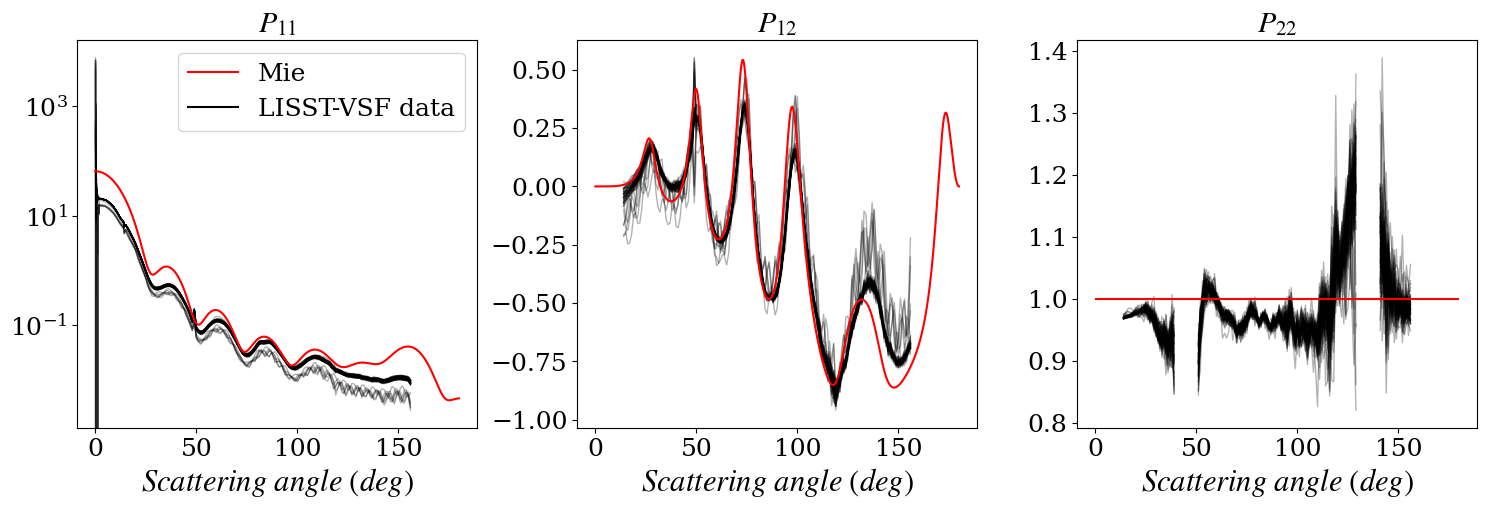

In [9]:
from matplotlib.lines import Line2D

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(16, 5), sharex=True)
fig.subplots_adjust(bottom=0.15, top=0.925, left=0.1, right=0.975,
                    hspace=0.1, wspace=0.25)
axs = axs.ravel()
plisst.P11.plot(hue='set', color='black', alpha=0.3, lw=1, add_legend=False, ax=axs[0])

plisst.p12.plot(hue='set', color='black', alpha=0.3, lw=1, add_legend=False, ax=axs[1])
plisst.p22.plot(hue='set', color='black', alpha=0.3, lw=1, add_legend=False, ax=axs[2])

axs[0].plot(ang,S11/norm,c='red',label='Mie')
axs[1].plot(ang,S12,c='red')
axs[2].hlines(1,0,180,colors='red')
axs[0].set_title('$P_{11}$')
axs[1].set_title('$P_{12}$')
axs[2].set_title('$P_{22}$')
for i in range(3):
    axs[i].set_xlabel('$Scattering\ angle\ (deg)$')
axs[0].semilogy()
handles, labels = axs[0].get_legend_handles_labels()
patch = Line2D([0],[0],color='black', label='LISST-VSF data')
handles.append(patch)
axs[0].legend(handles=handles, loc='upper right')
plt.show()

In [27]:


fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(16, 5), sharex=True)
fig.subplots_adjust(bottom=0.125, top=0.95, left=0.05, right=0.975,
                    hspace=0.1, wspace=0.25)
axs = axs.ravel()
b.P11.plot(hue='set', color='black', alpha=0.3, lw=1, add_legend=False, ax=axs[0])
b.p12.plot(hue='set', color='black', alpha=0.3, lw=1, add_legend=False, ax=axs[1])
b.p22.plot(hue='set', color='black', alpha=0.3, lw=1, add_legend=False, ax=axs[2])

axs[0].semilogy()
for i in range(3):
    axs[i].minorticks_on()
plt.show()

NameError: name 'b' is not defined